In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import os
import sys
sys.path.append( '/home/ebutz/ESL2024/code/utils' )
import play_with_complex as pwc


import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F


from nxontology.imports import from_file

import regex as re

def get_nodelist(df, node_type):
    nodelist = set()

    def process_node(series, regex_pattern):
        for val in series:
            if '|' in str(val) and re.match(regex_pattern, str(val)):
                for node in str(val).split('|'):
                    nodelist.add(node)
            else:
                if re.match(regex_pattern, str(val)):
                    nodelist.add(val)

    match node_type:
        case 'genes':
            # Use vectorized operations to improve performance
            source_nodes = df['source_node'].str.extract(r'(^OsNippo\S+)').dropna()
            nodelist.update(source_nodes.squeeze())
            
            # Split the 'interacts_with' column and add nodes to the set
            interacts_with_nodes = df['interacts_with'].str.split('|').explode().dropna()
            nodelist.update(interacts_with_nodes)

        case 'go':
            pattern = r'^GO:\d{7}'
            process_node(df['source_node'], pattern)
            process_node(df['gene ontology'], pattern)
            process_node(df['is_a'], pattern)

        case 'po':
            pattern = r'^PO:\d{7}'
            process_node(df['source_node'], pattern)
            process_node(df['plant ontology'], pattern)
            process_node(df['is_a'], pattern)

        case 'traito':
            pattern = r'^TO:\d{7}'
            process_node(df['source_node'], pattern)
            process_node(df['trait ontology'], pattern)
            process_node(df['is_a'], pattern)

        case 'prosite_profiles':
            pattern = r'^PS\d{5}'
            process_node(df['prosite_profiles'], pattern)

        case 'prosite_patterns':
            pattern = r'^PS\d{5}'
            process_node(df['prosite_patterns'], pattern)

        case 'superfamily':
            pattern = r'^SSF\d{5}'
            process_node(df['superfamily'], pattern)

        case 'panther':
            pattern = r'^PTHR\d{5}'
            process_node(df['panther'], pattern)
            # Remove in nodelist all nodes matching panther pattern that contain a ':' (avoids duplicates due to subfamilies)
            nodelist = {node for node in nodelist if  re.match(r'^[^:]*$', node)}

        case 'prints':
            pattern = r'^PR\d{5}'
            process_node(df['prints'], pattern)
        
        case _:
            nodelist.update(df[node_type].dropna().unique().tolist())

    return list(nodelist)


/home/ebutz/miniconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# ------------- Paths ------------- #

# Iric
csv_iric  = '/home/ebutz/ESL2024/data/full_iric/iric.csv'
tsv_iric   = '/home/ebutz/ESL2024/data/full_iric/iric.tsv'

print("\nLoading ontology...")
nxo = from_file('/home/ebutz/ESL2024/data/go-basic.json.gz')
nxo.freeze()
pwc.nxo = nxo
df = pd.read_csv(csv_iric, index_col=0, dtype=str)


Loading ontology...


In [5]:
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

# # ------------- Making global variables accessibles to pwc ------------- #

print(idx_to_go)
# {0: 'GO:0033540', 1: 'GO:0140584', 2: 'GO:1904102', 3: 'GO:0061631', 4: 'GO:0071323', 5: 'GO:0032407', 6: 'GO:0043599', 7: 'GO:0003137', 8: 'GO:1904853'
# {0: 'GO:0080175', 1: 'GO:1903019', 2: 'GO:0035049', 3: 'GO:0070314', 4: 'GO:1905841', 5: 'GO:0045523', 6: 'GO:0070549', 7: 'GO:0051401', 8: 'GO:0071388'

{0: 'GO:0033540', 1: 'GO:0140584', 2: 'GO:1904102', 3: 'GO:0061631', 4: 'GO:0071323', 5: 'GO:0032407', 6: 'GO:0043599', 7: 'GO:0003137', 8: 'GO:1904853', 9: 'GO:0030197', 10: 'GO:0160064', 11: 'GO:0098905', 12: 'GO:0044878', 13: 'GO:2001281', 14: 'GO:0034189', 15: 'GO:0075321', 16: 'GO:0030075', 17: 'GO:1903590', 18: 'GO:0160036', 19: 'GO:0002698', 20: 'GO:0032921', 21: 'GO:0008803', 22: 'GO:1990408', 23: 'GO:0034218', 24: 'GO:0050777', 25: 'GO:0022612', 26: 'GO:0030795', 27: 'GO:0047097', 28: 'GO:0004360', 29: 'GO:0034917', 30: 'GO:0046371', 31: 'GO:1904317', 32: 'GO:0019527', 33: 'GO:0018811', 34: 'GO:0044327', 35: 'GO:0034241', 36: 'GO:0010086', 37: 'GO:0046521', 38: 'GO:0072305', 39: 'GO:0017080', 40: 'GO:0015146', 41: 'GO:0061496', 42: 'GO:0046276', 43: 'GO:0072542', 44: 'GO:0045035', 45: 'GO:0015744', 46: 'GO:0006229', 47: 'GO:0006315', 48: 'GO:0120308', 49: 'GO:0071170', 50: 'GO:0160080', 51: 'GO:0030291', 52: 'GO:0004368', 53: 'GO:0090131', 54: 'GO:0150116', 55: 'GO:0140364', 5

In [9]:
triples = pd.read_csv(tsv_iric, sep = '\t')
triples = triples[triples['object'].str.contains('GO.', regex=True)]
display(triples)

,subject,predicate,object
0,GO:0000001,is_a,GO:0048311
1,GO:0000001,is_a,GO:0048308
2,GO:0000002,is_a,GO:0007005
3,GO:0000003,is_a,GO:0008150
4,GO:0000006,is_a,GO:0005385
...,...,...,...
1418543,OsNippo12g248550,gene ontology,GO:0009409
1418544,OsNippo12g248550,gene ontology,GO:0001666
1418564,OsNippo12g250550,gene ontology,GO:0008270
1418567,OsNippo12g255100,gene ontology,GO:0005576


In [2]:
print("\nImports...")

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import os
import sys
sys.path.append( '/home/ebutz/ESL2024/code/utils' )
import play_with_complex as pwc


import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F


from nxontology.imports import from_file

# ------------- Paths ------------- #

# Iric
mapped_iric_path  = '/home/ebutz/ESL2024/data/Os_to_GO_iric/altailed_Os_to_GO_iric.pickle'
altails_dict_path = '/home/ebutz/ESL2024/data/Os_to_GO_iric/DICT_altailed_Os_to_GO_iric.pickle'

# Model to train :
hidden_channels = 5
batch_size      = 4096
epochs          = 150
eval_period     = 2
lin_factor      = 1
xp_name = f'LinSim labels vs others on full dataset with 6*{hidden_channels} HC'

params_save_name = f"PARAMS_ComplEx_6_times_{hidden_channels}_HC_{epochs}_epochs_{batch_size}_BS_on_full_iric"
model_parameters_path = "/home/ebutz/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/"+params_save_name

# Ontology
ontology_path = "/home/ebutz/ESL2024/data/go-basic.json.gz"
check_dicts = False

# ------------- Cuda ------------- #

device = 'cpu'
print(f"Device: '{device}'")
print("Could reach GPU :", torch.Tensor([0,1]).to(device).is_cuda)


# ------------- Loading datas ------------- #

print("\nLoading iric...")
mapped_iric = pd.read_pickle(mapped_iric_path)
print(mapped_iric.head())
print('mapped_alt_tails type :', type(mapped_iric.iloc[0]['mapped_alt_tails']))

GO_to_map = mapped_iric.set_index('object')['mapped_object'].to_dict()
map_to_GO = {value: key for key, value in GO_to_map.items()}

if check_dicts:
    looks_ok: bool = True
    for i in tqdm(range(len(list(mapped_iric['object']))), desc = "Checking GO to MAP dict"):
        if GO_to_map[mapped_iric['object'][i]]!=mapped_iric['mapped_object'][i] :
            looks_ok = False
    print('GO - Mapping dicts looks ok :', looks_ok)

with open(altails_dict_path, 'rb') as handle:
    mapped_alt_tails = pickle.load(handle)
print("Alternative tails dict (first key-value pair):", list(mapped_alt_tails.items())[0])

# # ------------- Making datasets ------------- #

print("\nMaking datasets...")
# Edges index :
heads = list(mapped_iric['mapped_subject'])
tails = list(mapped_iric['mapped_object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
# edges attributes :
edge_attributes = torch.tensor(mapped_iric['mapped_predicate'])


iric_pyg = Data(
                num_nodes = len(set(mapped_iric['object']).union(set(mapped_iric['subject']))),
                edge_index = edge_index,
                edge_attr = edge_attributes
                )

print(iric_pyg)

print("\nDataset looks valid :",iric_pyg.validate(raise_on_error=True))

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected = False,
                            add_negative_train_samples = False,
                            )

train_set, val_set, test_set = transform(iric_pyg)
print('Dataset splits look valid (train, val, test):',train_set.validate(raise_on_error = True),
                                                      val_set.validate(raise_on_error   = True),
                                                      test_set.validate(raise_on_error  = True))

# ------------- Loading ontology ------------- #

print("\nLoading ontology...")
nxo = from_file(ontology_path)
nxo.freeze()

# ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = map_to_GO
pwc.nxo              = nxo
pwc.mapped_alt_tails = mapped_alt_tails
pwc.device           = device

# ------------- Init model ------------- #

LinSim_labels = pwc.ComplEx_with_LinSim_labels(
                                    num_nodes       = train_set.num_nodes,
                                    num_relations   = train_set.edge_index.size()[1],
                                    hidden_channels = hidden_channels,
                                    ).to(device)
# pwc.train_and_test_complex(model      = LinSim_labels,
    #                         train_data = train_set,
    #                         test_data  = test_set,
    #                         device     = device,
    #                         use_wandb  = False,
    #                         xp_name    = xp_name,
    #                         run_name   = 'LinSim_labels',
    #                         eval_period= eval_period,
    #                         epochs = epochs
    #                         )


Imports...
Device: 'cpu'
Could reach GPU : False

Loading iric...
            subject      predicate      object  mapped_subject  \
0  OsNippo01g010050  gene ontology  GO:0031267           29269   
1  OsNippo01g010050  gene ontology  GO:0006886           29269   
2  OsNippo01g010050  gene ontology  GO:0005622           29269   
3  OsNippo01g010050  gene ontology  GO:0005623           29269   
4  OsNippo01g010050  gene ontology  GO:0090630           29269   

   mapped_predicate  mapped_object                            mapped_alt_tails  
0                 0           8105  [20179, 25142, 11107, 11397, 25543, 24490]  
1                 0          20179   [8105, 25142, 11107, 11397, 25543, 24490]  
2                 0          25142   [8105, 20179, 11107, 11397, 25543, 24490]  
3                 0          11107   [8105, 20179, 25142, 11397, 25543, 24490]  
4                 0          11397   [8105, 20179, 25142, 11107, 25543, 24490]  
mapped_alt_tails type : <class 'numpy.ndarray'>
Al

In [43]:
loader = LinSim_labels.loader(
    head_index = train_set.edge_index[0],
    tail_index = train_set.edge_index[1],
    rel_type = train_set.edge_attr,
    batch_size=batch_size,
    shuffle=False,)

batchy = next(iter(loader))
print(batchy)

(tensor([11624,  5886, 22042,  ...,  9219, 17939,  2744]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 4594, 16674, 18244,  ...,  4900,  8874, 27984]))


In [44]:
bls = pwc.best_lin_sims_for_batch(*batchy)
print('non-zero :',torch.count_nonzero(bls))
print(bls.size())


non-zero : tensor(3517)
torch.Size([4096])


In [45]:
from torch.nn.functional import normalize as norm
nbls = norm(bls, dim = 0)
print(nbls)

tensor([0.0053, 0.0210, 0.0227,  ..., 0.0173, 0.0186, 0.0000])


In [46]:
nbls.size()[0]

4096

In [47]:
for i in range(nbls.size()[0]):
    print(bls[i],nbls[i])

tensor(0.2261) tensor(0.0053)
tensor(0.8983) tensor(0.0210)
tensor(0.9741) tensor(0.0227)
tensor(0.7972) tensor(0.0186)
tensor(0.) tensor(0.)
tensor(0.5869) tensor(0.0137)
tensor(0.9283) tensor(0.0217)
tensor(0.8973) tensor(0.0209)
tensor(0.6928) tensor(0.0162)
tensor(0.6214) tensor(0.0145)
tensor(0.8674) tensor(0.0202)
tensor(0.1074) tensor(0.0025)
tensor(0.1759) tensor(0.0041)
tensor(0.6916) tensor(0.0161)
tensor(0.9003) tensor(0.0210)
tensor(0.5359) tensor(0.0125)
tensor(0.9158) tensor(0.0214)
tensor(0.7688) tensor(0.0179)
tensor(0.3335) tensor(0.0078)
tensor(0.8894) tensor(0.0207)
tensor(0.8669) tensor(0.0202)
tensor(0.9335) tensor(0.0218)
tensor(0.) tensor(0.)
tensor(0.3905) tensor(0.0091)
tensor(0.9341) tensor(0.0218)
tensor(0.4709) tensor(0.0110)
tensor(0.7343) tensor(0.0171)
tensor(0.) tensor(0.)
tensor(0.5774) tensor(0.0135)
tensor(0.1129) tensor(0.0026)
tensor(0.5987) tensor(0.0140)
tensor(0.4547) tensor(0.0106)
tensor(0.9665) tensor(0.0225)
tensor(0.9575) tensor(0.0223)
tens

In [ ]:
print("\nImports...")

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import os
import sys
sys.path.append( '/home/ebutz/ESL2024/code/utils' )
import play_with_complex as pwc


import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F


from nxontology.imports import from_file

# ------------- Paths ------------- #

# Iric
mapped_iric_path  = '/home/ebutz/ESL2024/data/Os_to_GO_iric/altailed_Os_to_GO_iric.pickle'
altails_dict_path = '/home/ebutz/ESL2024/data/Os_to_GO_iric/DICT_altailed_Os_to_GO_iric.pickle'

# Model to train :
hidden_channels = 176
batch_size      = 4096
epochs          = 150
eval_period     = 2
lin_factor      = 1

params_save_name = f"PARAMS_ComplEx_6_times_{hidden_channels}_HC_{epochs}_epochs_{batch_size}_BS_on_full_iric"
model_parameters_path = "/home/ebutz/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/"+params_save_name

# Ontology
ontology_path = "/home/ebutz/ESL2024/data/go-basic.json.gz"
check_dicts = False

# ------------- Cuda ------------- #

print("\nCuda check...")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
print("Could reach GPU :", torch.Tensor([0,1]).to(device).is_cuda)


# ------------- Loading datas ------------- #

print("\nLoading iric...")
mapped_iric = pd.read_pickle(mapped_iric_path)
print(mapped_iric.head())
print('mapped_alt_tails type :', type(mapped_iric.iloc[0]['mapped_alt_tails']))

GO_to_map = mapped_iric.set_index('object')['mapped_object'].to_dict()
map_to_GO = {value: key for key, value in GO_to_map.items()}

if check_dicts:
    looks_ok: bool = True
    for i in tqdm(range(len(list(mapped_iric['object']))), desc = "Checking GO to MAP dict"):
        if GO_to_map[mapped_iric['object'][i]]!=mapped_iric['mapped_object'][i] :
            looks_ok = False
    print('GO - Mapping dicts looks ok :', looks_ok)

with open(altails_dict_path, 'rb') as handle:
    mapped_alt_tails = pickle.load(handle)
print("Alternative tails dict (first key-value pair):", list(mapped_alt_tails.items())[0])

# # ------------- Making datasets ------------- #

print("\nMaking datasets...")
# Edges index :
heads = list(mapped_iric['mapped_subject'])
tails = list(mapped_iric['mapped_object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
# edges attributes :
edge_attributes = torch.tensor(mapped_iric['mapped_predicate'])


iric_pyg = Data(
                num_nodes = len(set(mapped_iric['object']).union(set(mapped_iric['subject']))),
                edge_index = edge_index,
                edge_attr = edge_attributes
                )

print(iric_pyg)

print("\nDataset looks valid :",iric_pyg.validate(raise_on_error=True))

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected = False,
                            add_negative_train_samples = False,
                            )

train_set, val_set, test_set = transform(iric_pyg)
print('Dataset splits look valid (train, val, test):',train_set.validate(raise_on_error = True),
                                                      val_set.validate(raise_on_error   = True),
                                                      test_set.validate(raise_on_error  = True))

# ------------- Loading ontology ------------- #

print("\nLoading ontology...")
nxo = from_file(ontology_path)
nxo.freeze()

# ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = map_to_GO
pwc.nxo              = nxo
pwc.mapped_alt_tails = mapped_alt_tails
pwc.device           = device


# ------------- Init model ------------- #

for hidden_channels in [176, 15, 50, 75, 150, 250, 350]:

    xp_name = f'LinSim labels vs others on full Os_to_GO dataset with 6*{hidden_channels} HC'


    L_U_LS_RLS = pwc.ComplEx_labels_LS_RLS_UL(
                                    num_nodes       = train_set.num_nodes,
                                    num_relations   = train_set.edge_index.size()[1],
                                    hidden_channels = hidden_channels,
                                    ).to(device)
    pwc.train_and_test_complex(model      = tail_only,
                            train_data = train_set,
                            test_data  = test_set,
                            device     = device,
                            use_wandb  = True,
                            xp_name    = xp_name,
                            run_name   = 'Baseline (Usual ComplEx tail only)',
                            eval_period= eval_period,
                            epochs = epochs
                            )

    

(array([3.558e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 8.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        8.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 1.200e+01, 4.000e+00,
        1.000e+01, 4.000e+00, 1.000e+01, 7.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.200e+01,
        7.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 1.300e+01, 9.000e+00, 4.000e+00, 1.500e+01, 1.000e+00,
        6.000e+00, 1.400e+01, 7.000e+0

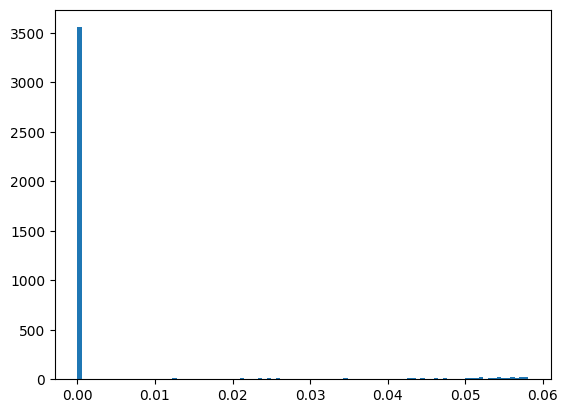

In [28]:

import matplotlib.pyplot as plt
plt.hist(x = nbls, bins = 100)


(array([3.558e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 8.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        8.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 1.200e+01, 4.000e+00,
        1.000e+01, 4.000e+00, 1.000e+01, 7.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.200e+01,
        7.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 1.300e+01, 9.000e+00, 4.000e+00, 1.500e+01, 1.000e+00,
        6.000e+00, 1.400e+01, 7.000e+0

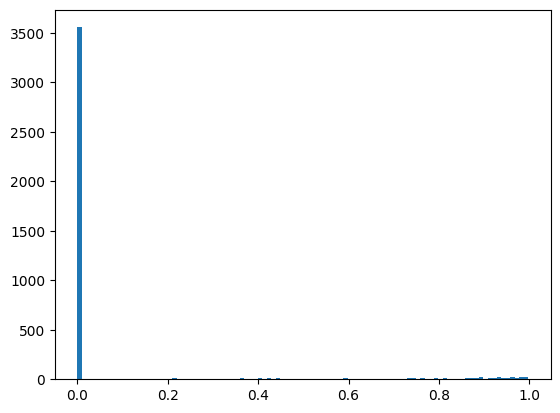

In [25]:
import matplotlib.pyplot as plt
plt.hist(x = bls, bins = 100)